### In this project we develop an updated first-order algorithm to construct a
portfolio using intraday data; now with position bounds and using projected gradients.

In [49]:
import csv
import sys
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

The assets that we will use are: ABR, AMZN, GS, NFLX, NIO, NVDA, TSLA, UBS.

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.

$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)$$

$$ \text{subject to} \ |x_j| \le 1 \ \text{for all names $j$}$$
#### Unlike what we did on project $2$, the risk term is **not** raised to the power $1/\pi$.


### <span style='color:red'> Develop a first-order method to address this computational problem.</span>

#### Your method should work with values of $T$ at least $100$.

#### Make sure your code works with $\pi = 2$ and $\pi = 4$.  For $\pi = 2$ use $\theta = 5$. You should be able to get meaningful problem behavior (i.e., nonzero portfolio).  And when $\pi = 4$ use $\theta = 1000$.
<br>

#### Suggestion: first apply the problem to one asset at a time, i.e., $n = 1$.  Then use $n = 2$.  And only then try the entire set of names.  And use $\pi = 2$ before trying $\pi = 4$.

Data import

In [50]:
#function that computes daily returns for a given stock data file and returns a 100x1 numpy array
def compute_daily_return_vector_cleaned(file_path):
    
    #get stock data and only keep the right columns
    stock_data = pd.read_csv(file_path, skiprows=3)
    keepcols = ["Dates", "Open", "Close"]
    stock_df = stock_data[keepcols]
    
    #filter out rows with invalid date values
    stock_df = stock_df[stock_df['Dates'] != "#NAME?"]
    stock_df = stock_df.dropna()
    
    stock_df['Dates'] = pd.to_datetime(stock_df['Dates'])
    
    #filter data for 9:30am and 12:00pm
    stock_930 = stock_df[stock_df['Dates'].dt.time == pd.to_datetime('9:30').time()]
    stock_1200 = stock_df[stock_df['Dates'].dt.time == pd.to_datetime('12:00').time()]

    #ensure that both dataframes have the same length for alignment
    common_dates = np.intersect1d(stock_930['Dates'].dt.date, stock_1200['Dates'].dt.date)
    stock_930 = stock_930[stock_930['Dates'].dt.date.isin(common_dates)]
    stock_1200 = stock_1200[stock_1200['Dates'].dt.date.isin(common_dates)]

    #calculate the daily return
    daily_return = ((stock_1200['Close'].values - stock_930['Open'].values) / stock_930['Open'].values)
    
    return daily_return[:100]

#process each stock with the function
abr_return_vector_cleaned = compute_daily_return_vector_cleaned("ABR.csv")
amzn_return_vector_cleaned = compute_daily_return_vector_cleaned("AMZN.csv")
gs_return_vector_cleaned = compute_daily_return_vector_cleaned("GS.csv")
nflx_return_vector_cleaned = compute_daily_return_vector_cleaned("NFLX.csv")
nio_return_vector_cleaned = compute_daily_return_vector_cleaned("NIO.csv")
nvda_return_vector_cleaned = compute_daily_return_vector_cleaned("NVDA.csv")
tsla_return_vector_cleaned = compute_daily_return_vector_cleaned("TSLA.csv")
ubs_return_vector_cleaned = compute_daily_return_vector_cleaned("UBS.csv")



#combine the results into a dataframe
df = pd.DataFrame({
    "ABR": abr_return_vector_cleaned,
    "AMZN": amzn_return_vector_cleaned,
    "GS": gs_return_vector_cleaned,
    "NFLX": nflx_return_vector_cleaned,
    "NIO": nio_return_vector_cleaned,
    "NVDA": nvda_return_vector_cleaned,
    "TSLA": tsla_return_vector_cleaned,
    "UBS": ubs_return_vector_cleaned,
})

#column of ones
df["ones"] = np.ones(100)

#column of means
df["ABR_m"] = df["ABR"].mean()
df["AMZN_m"] = df["AMZN"].mean()
df["GS_m"] = df["GS"].mean()
df["NFLX_m"] = df["NFLX"].mean()
df["NIO_m"] = df["NIO"].mean()
df["NVDA_m"] = df["NVDA"].mean()
df["TSLA_m"] = df["TSLA"].mean()
df["UBS_m"] = df["UBS"].mean()

#column of excess return
df["ABR_e"] = df["ABR"] - df["ABR_m"]
df["AMZN_e"] = df["AMZN"] - df["AMZN_m"]
df["GS_e"] = df["GS"] - df["GS_m"]
df["NFLX_e"] = df["NFLX"] - df["NFLX_m"]
df["NIO_e"] = df["NIO"] - df["NIO_m"]
df["NVDA_e"] = df["NVDA"] - df["NVDA_m"]
df["TSLA_e"] = df["TSLA"] - df["TSLA_m"]
df["UBS_e"] = df["UBS"] - df["UBS_m"]


#excessmatrix
excessmat = df[["ABR_e","AMZN_e", "GS_e", "NFLX_e","NIO_e","NVDA_e","TSLA_e","UBS_e"]]
ones = df["ones"]

t= df.shape[0]
n= df.shape[1]

#array of means
mean = np.array([df["ABR"].mean(),df["AMZN"].mean(),df["GS"].mean(),df["NFLX"].mean(),df["NIO"].mean(),df["NVDA"].mean(),df["TSLA"].mean(),df["UBS"].mean()])


C:\Users\loicb\AppData\Local\Temp\ipykernel_16272\2701970002.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_data = pd.read_csv(file_path, skiprows=3)
C:\Users\loicb\AppData\Local\Temp\ipykernel_16272\2701970002.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_df['Dates'] = pd.to_datetime(stock_df['Dates'])
C:\Users\loicb\AppData\Local\Temp\ipykernel_16272\2701970002.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_data = pd.read_csv(file_path, skiprows=3)
C:\Users\loicb\AppData\Local\Temp\ipykernel_16272\2701970002.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_data = pd.read_csv(file_path, skiprows=3)
C:\Users\loicb\AppData\Local\Temp\ipykern

Function definition and gradient definition

In [51]:
pi = 2
theta = 5
print(mean)

[-0.00029461 -0.00024606  0.00156226 -0.00025465 -0.00329561 -0.0010894
 -0.00067218  0.00101647]


In [52]:
#Function to evaluate:
def evalfun(x,t,mean, theta, pi,excessmat,ones):
    
    #left hand side of equation
    lhs = -1*mean@x
            
    #innermost sum of rhs expression
    innersum = (excessmat@x)**pi

    #total rhs expresiion
    rhs = theta*(1/t*(ones@innersum))

    return lhs + rhs

In [53]:
#Function to evaluate the gradient
def evalgrad(x,t,mean,theta,pi,excessmat,ones):

    #gradient of Lhs is simply - ri_m

    grad = []
    for i in range(8):
        grad.append(-1*mean[i])
    
    gradarray = np.array(grad)

    insum = pi*excessmat@x    
    for i in range(len(x)):    
        gradarray[i] += theta/t*ones@(insum*excessmat.iloc[:,i]).T

    

    #We dont normalize so that we can use the convergence criterion of small sized gradient
    #gradarraynorm = gradarray/np.linalg.norm(gradarray)

    return gradarray

Gradient descent algorithm with a constraint

In [54]:
#epsilon ensures the constraints are respected
epsilon = 1-0.01

def backtrack(x,fval,gradarray,deltaarray,t,mean,theta,pi,excessmat,ones, loud):
    alpha = 0.5   
    beta = 0.75
    zerotol = 0.1 #used to detect when a step is too short, since the gradient is not normalized, we can have large steps
    gradtimesdelta = gradarray@deltaarray
    
    if loud:
        print('grad times delta = {:.4e}'.format(gradtimesdelta))
    
    w = 1
    goon = True

    #This logic is extra precaution so that if a step is large, we dont go over to the other side
    #This never happens
    for i in range(len(x)):
       if x[i] > 0:
         if x[i] + w*deltaarray[i] <= -1*epsilon:
           print("went to other side")
           w = (x[i] + epsilon)/(abs(deltaarray[i]))
       else:
         if x[i] + w*deltaarray[i] >= epsilon:
           print("went to other side")
           w = (epsilon - x[i])/(abs(deltaarray[i]))

       if w <= zerotol:
         w = 0
         goon = False

    while goon:
        fnew = evalfun(x+w*deltaarray,t,mean,theta,pi,excessmat,ones)
        target = alpha*w*gradtimesdelta

        if fnew - fval <= target:
            goon = False
            if loud:
                print('done!')
        else:
            w = beta*w
        if w < zerotol:
            goon = False
    return w

In [55]:
def fixedratestep_projected_backtrack(x, fvalue, epsilon,t,mean,theta,pi,excessmat,ones):
    
    #evaluate the gradient and create the delta array
    gradarray = evalgrad(x,t,mean,theta,pi,excessmat,ones)
    deltaarray = -1*gradarray

    #logic to project the gradient if we are very near to a constraint
    for i in range(len(x)):
        #If x is negative and smaller or equal to epsilon, we force to move in a positive or null direction
        if x[i] < 0 :
            if abs(x[i]) >= epsilon: deltaarray[i] = max(0, deltaarray[i])
            
        #If x is positive and larger or equal to epsilon, we force to move in a negative or null direction
        else:
            if abs(x[i]) >= epsilon: deltaarray[i] = min(0,deltaarray[i])
            
    #we can now backtrack with the right deltaarray
    w = backtrack(x,fvalue,gradarray,deltaarray,t,mean,theta,pi,excessmat,ones,False)
    print(f"got w = {w}")
    return w, deltaarray

Note: The code works and gives the final x and objective value no matter the starting point.

In [56]:
# Let's try again
N = 10000
fvalsol = np.zeros(N)

#Uncomment this if we want to test for random x
#x = np.random.uniform(-epsilon, epsilon, size=8)

x = np.zeros(8)
print(f"initial guess is {x}")


for iteration in range(N):
    print('\nIteration', iteration)

    #calculate value
    fvalue = evalfun(x,t,mean,theta,pi,excessmat,ones)
    fvalsol[iteration] = fvalue

    #find step size and appropriate deltaarray (with projections)
    w, deltaarray = fixedratestep_projected_backtrack(x, fvalue, epsilon,t,mean,theta,pi,excessmat,ones)


    print(' Backtracking yielded step = ', w)
    
    #find new x value
    newx = x + w*deltaarray

    #reevaluate the function
    newfval = evalfun(newx,t,mean,theta,pi,excessmat,ones)

    x = newx

    # If we get a small value for the gradient, we say we have converged
    # We apply a very strict criterion for convergence, explaining that it takes several steps.
    # This makes sure we have convergence even when theta = 1000 and pi = 4
    if np.sum((-1*deltaarray)**2) <= 1e-11:
      print(f'Breaking off after {iteration} iterations')
      break
  
print(f"the final value is {fvalue}")
print(f"the final x array is {x}")


initial guess is [0. 0. 0. 0. 0. 0. 0. 0.]

Iteration 0
got w = 1
 Backtracking yielded step =  1

Iteration 1
got w = 1
 Backtracking yielded step =  1

Iteration 2
got w = 1
 Backtracking yielded step =  1

Iteration 3
got w = 1
 Backtracking yielded step =  1

Iteration 4
got w = 1
 Backtracking yielded step =  1

Iteration 5
got w = 1
 Backtracking yielded step =  1

Iteration 6
got w = 1
 Backtracking yielded step =  1

Iteration 7
got w = 1
 Backtracking yielded step =  1

Iteration 8
got w = 1
 Backtracking yielded step =  1

Iteration 9
got w = 1
 Backtracking yielded step =  1

Iteration 10
got w = 1
 Backtracking yielded step =  1

Iteration 11
got w = 1
 Backtracking yielded step =  1

Iteration 12
got w = 1
 Backtracking yielded step =  1

Iteration 13
got w = 1
 Backtracking yielded step =  1

Iteration 14
got w = 1
 Backtracking yielded step =  1

Iteration 15
got w = 1
 Backtracking yielded step =  1

Iteration 16
got w = 1
 Backtracking yielded step =  1

Iteration 17
g

Note for graph: The following graph can show weird behavior when using pi = 4 and theta = 1000. Indeed, when the initial guess is near a boundary, the projection occurs and this can lead to the objective function increasing for the next few iterations. This happens with theta 1000 which increases the gradient, making the delta larger and more likely to send the x values near a constraint at every step.

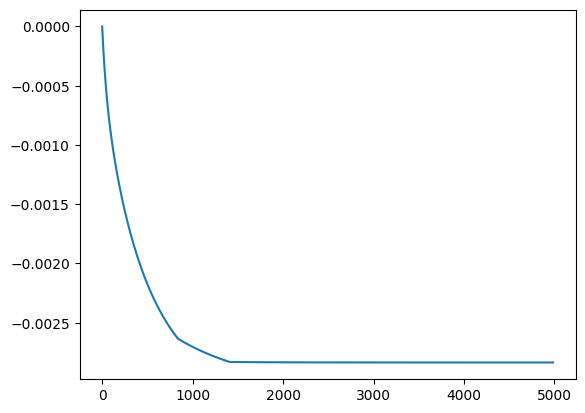

In [57]:
plt.plot(range(len(fvalsol[:iteration])),fvalsol[:iteration])
plt.show()

### <span style='color:red'>**Extra credit**</span>
#### Suppose $x^*$ is the solution you compute above.  Next, solve the same optimization problem as above, except that you now have the constraint:
$$ \sum_j | x_j | \ \le \ 0.5*\sum_j |x^*_j |$$

Use a first-order barrier method, as covered in class, for this purpose.

We now have a function that is bounded by the sum of half of our previous result

In [58]:
#The solution we computed above is x
finalsol = x
finalsum = 0.5*np.sum(abs(finalsol))
print(finalsum)


1.7618435789060802


Putting all element of the constraint on the right hand side, we get: $$ 0 \ \le \  0.5*\sum_j |x^*_j | - \sum_j | x_j |$$

We now want a function that goes to infinity when approaching 0 from the right and is relatively small if it is greater than 0. Such a function could be -log(t) where t is 
$$t = 0.5*\sum_j |x^*_j | - \sum_j | x_j |$$

The objective function with the barrier is now the following, where lambda is a hyperparamter we can change: 
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right) - \lambda*log(0.5*\sum_j |x^*_j | - \sum_j | x_j |)$$


In [59]:
#Function to evaluate:
def evalfun_barrier(x,t,mean, theta, pi,excessmat,ones, finalsum,lamb):
    
    #left hand side of equation
    lhs = -1*mean@x
            
    #innermost sum of rhs expression
    innersum = (excessmat@x)**pi

    #total rhs expresiion
    rhs = theta*(1/t*(ones@innersum))

    #barrier
    if finalsum-np.sum(abs(x)) == 0 :
        print("barrier at 0")
    else:
        barrier = -lamb*np.log((finalsum-np.sum(abs(x))))

    #We add lambda to the final result
    return lhs + rhs + barrier

In [60]:
#Function to evaluate the gradient
def evalgrad_barrier(x,t,mean,theta,pi,excessmat,ones,finalsum, lamb):

    #gradient of Lhs is simply - ri_m
    grad = []
    gr = []
    insum = pi*excessmat@x**(pi-1)
    gradar = []

    #gradient of the barrier
    gbar = lamb/(finalsum-np.sum(abs(x)))

    for i in range(8):
        grad.append(-1*mean[i])
        gr.append(theta/t*ones@(insum*excessmat.iloc[:,i]).T)
        gradar.append(grad[i] + gr[i] + gbar)

    gradarray = np.array(gradar)

    #We dont normalize so that we can use the convergence criterion of small sized gradient
    #gradarray = gradarray/np.linalg.norm(gradarray)

    return gradarray

Note: we allow for a smaller step size because if not, a large step size could send us into a xarray that makes (0.5* sum x*j - sum of x) negative, which is undefined for the log

In [61]:
epsilon = 1-0.01

def backtrack_barrier(x,fval,gradarray,deltaarray,t,mean,theta,pi,excessmat,ones,finalsum,lamb, loud):
    alpha = 0.5
    beta = 0.75
    zerotol = 0.00001 #used to detect when a step is too short
    gradtimesdelta = gradarray@deltaarray
    
    if loud:
        print('grad times delta = {:.4e}'.format(gradtimesdelta))
    
    w = 1
    goon = True

    #This logic is extra precaution so that if a step is large, we dont go over to the other side
    #This never happens
    for i in range(len(x)):
       if x[i] > 0:
         if x[i] + w*deltaarray[i] <= -1*epsilon:
           print("went to other side")
           w = (x[i] + epsilon)/(abs(deltaarray[i]))
       else:
         if x[i] + w*deltaarray[i] >= epsilon:
           print("went to other side")
           w = (epsilon - x[i])/(abs(deltaarray[i]))

       if w <= zerotol:
         w = 0
         goon = False

    while goon:
        fnew = evalfun_barrier( x+w*deltaarray,t,mean,theta,pi,excessmat,ones,finalsum,lamb)
        target = alpha*w*gradtimesdelta

        #If the step taken led to a xarray that is negative inside the log, we take a smaller step
        if math.isnan(fnew):
            w = beta*w
        
        elif fnew - fval <= target:
            goon = False
        else:
            w = beta*w
            
        if w < zerotol:
            goon = False
    return w

In [62]:
def fixedratestep_projected_backtrack_barrier(x, fvalue, epsilon,t,mean,theta,pi,excessmat,ones,finalsum,lamb):
    
    gradarray = evalgrad_barrier(x,t,mean,theta,pi,excessmat,ones,finalsum,lamb)
    deltaarray = -1*gradarray

    #logic to project the gradient if we are very near to a constraint
    for i in range(len(x)):
        #If x is negative and smaller or equal to -1 * epsilon, we force to move in a positive or null direction
        if x[i] < 0 : 
            if abs(x[i]) >= epsilon: deltaarray[i] = max(0, deltaarray[i])
            
        #If x is positive and larger or eqeual to epsilon, we force to move in a negative or null direction
        else:
            if abs(x[i]) >= epsilon: deltaarray[i] = min(0,deltaarray[i])
                
    
    w = backtrack_barrier(x,fvalue,gradarray,deltaarray,t,mean,theta,pi,excessmat,ones,finalsum,lamb,False)
    print(f"got w = {w}")
    return w, deltaarray

In [63]:
# Let's try again
N = 1000
fvalsolb = np.zeros(N)
xb = np.random.uniform(-0.1, 0.1, size=8)

#xb = np.zeros(8)
print(f"initial guess is {xb}")

#A small lambda value makes the log function larger as we approach 0
lamb = 0.0001


for iteration in range(N):
    print('\nIteration', iteration)

    #calculate value
    fvalueb = evalfun_barrier(xb,t,mean,theta,pi,excessmat,ones,finalsum,lamb)
    fvalsolb[iteration] = fvalueb

    #find step size and appropriate deltaarray (with projections)
    w, deltaarray = fixedratestep_projected_backtrack_barrier(xb, fvalueb, epsilon,t,mean,theta,pi,excessmat,ones,finalsum,lamb)


    print(' Backtracking yielded step = ', w)
    
    #find new x value
    newxb = xb + w*deltaarray

    #reevaluate the function
    newfvalb = evalfun_barrier(newxb,t,mean,theta,pi,excessmat,ones,finalsum,lamb)

    xb = newxb

    if np.sum((-1*deltaarray)**2) <= 1e-6:
      print(f'Breaking off after {iteration} iterations')
      break
  
print(f"the final value is {fvalueb}")
print(f"the final x array is {xb}")


initial guess is [ 0.08825846  0.07457398 -0.09260451  0.06212731 -0.06438686  0.03749792
 -0.05359138 -0.04555803]

Iteration 0
got w = 1
 Backtracking yielded step =  1

Iteration 1
got w = 1
 Backtracking yielded step =  1

Iteration 2
got w = 1
 Backtracking yielded step =  1

Iteration 3
got w = 1
 Backtracking yielded step =  1

Iteration 4
got w = 1
 Backtracking yielded step =  1

Iteration 5
got w = 1
 Backtracking yielded step =  1

Iteration 6
got w = 1
 Backtracking yielded step =  1

Iteration 7
got w = 1
 Backtracking yielded step =  1

Iteration 8
got w = 1
 Backtracking yielded step =  1

Iteration 9
got w = 1
 Backtracking yielded step =  1

Iteration 10
got w = 1
 Backtracking yielded step =  1

Iteration 11
got w = 1
 Backtracking yielded step =  1

Iteration 12
got w = 1
 Backtracking yielded step =  1

Iteration 13
got w = 1
 Backtracking yielded step =  1

Iteration 14
got w = 1
 Backtracking yielded step =  1

Iteration 15
got w = 1
 Backtracking yielded step =  

we notice that we do not "officially" converge since the gradient gets smaller very slowly. towards the later iterations. However, we get a similar objective value (around -0.0014) even with different starting points, showing that we are near the right answer.

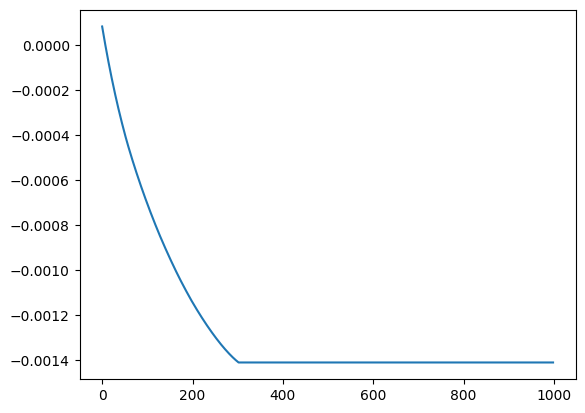

In [64]:
plt.plot(range(len(fvalsolb[:iteration])),fvalsolb[:iteration])
plt.show()